# Experiment:1 10 Food Classes (Food101 Mini)

* Transfer Learning (Feature Extraction + Fine Tuning)
on all classes (Food101).
* Goal  --> Beat Food101 orginal paper (50+% accuracy).

In [ ]:
!nvidia-smi

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir 

## Datasets 10-percent of 101 food classes.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2022-01-08 12:39:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   216MB/s    in 7.3s    

2022-01-08 12:39:38 (213 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
# Setting up the datasets inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size = IMG_SIZE,
                                                                             batch_size = 32,
                                                                             label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                batch_size = 32,
                                                                label_mode = "categorical",
                                                                shuffle = False) # for prediction analysis in future for the order
                      

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with Transfer Learning on 10% of 101 food classes
**Steps:**

1. Create a ModelCheckpoint callback.
2. Create Data Augmentation layer.
3. Build headless (no top layer) functional EfficientNet B0 backboned-model.
4. Compile Model
5. Feature Extract (5 epochs and evaluate on only 15% of test data) 

In [ ]:
# Create ModelCheckpoint Callback

checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                        save_weights_only = True,
                                                        monitor = "val_accuracy",
                                                        save_best_only = True)

In [ ]:
# Data_Augmentation layer

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing 

data_augmentation = Sequential([
           # experiment on these maybe model will work better without some layer or maybe not                     
           preprocessing.RandomFlip("horizontal"),
           preprocessing.RandomZoom(0.2),
           preprocessing.RandomWidth(0.2),
           preprocessing.RandomHeight(0.2),
           preprocessing.RandomRotation(0.2),
          #  preprocessing.Rescaling(1/225.)          
], name = "Data_Augmentation_layer")


In [ ]:
# Build headless (no top layer) functional EfficientNet B0 backboned-model.
# for feature extraction ( freeze layers )

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# setting-up model architecture with trainable top layers
inputs = layers.Input( shape = IMG_SIZE + (3,), name = "Input_layer")

x = data_augmentation(inputs)

x = base_model(x , training = False) # inference mode, weights stay frozen

x = layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "Output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compiling and fitting

initial_epochs = 5

model.compile( loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

history = model.fit(train_data_all_10_percent,
                    epochs = initial_epochs,
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [
                                 create_tensorboard_callback(dir_name = "Food101 Mini",
                                                             experiment_name = "Model_10_percent_all_data"),
                                 checkpoint_callback
                    ])

Saving TensorBoard log files to: Food101 Mini/Model_10_percent_all_data/20220108-124637
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - 131s 488ms/step - loss: 3.4714 - accuracy: 0.2539 - val_loss: 2.7827 - val_accuracy: 0.3713
Epoch 2/5
237/237 [==============================] - 94s 396ms/step - loss: 2.3528 - accuracy: 0.4618 - val_loss: 2.3619 - val_accuracy: 0.4288
Epoch 3/5
237/237 [==============================] - 92s 387ms/step - loss: 2.0131 - accuracy: 0.5167 - val_loss: 2.1526 - val_accuracy: 0.4650
Epoch 4/5
237/237 [==============================] - 76s 319ms/step - loss: 1.7915 - accuracy: 0.5604 - val_loss: 2.0897 - val_accuracy: 0.4658
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.6470 - accuracy: 0.6046 - val_loss: 2.0181 - val_accuracy: 0.4844


In [ ]:
feature_extration_results = model.evaluate(test_data)

790/790 [==============================] - 102s 129ms/step - loss: 1.7227 - accuracy: 0.5529


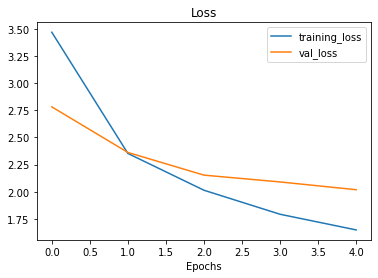

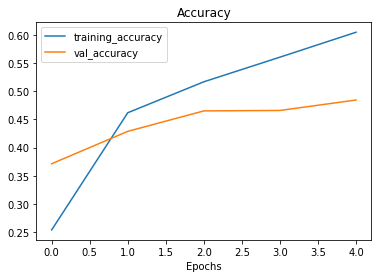

In [ ]:
plot_loss_curves(history)

## Fine-Tuning

In [ ]:
# Unfreeze all
base_model.trainable = True

# freeze all except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [ ]:
# recompile with lower lr when fine tuning

model.compile( loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])



In [ ]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
history_1 = model.fit(
    train_data_all_10_percent,
    epochs = initial_epochs + 5,
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = history.epoch[-1],
    callbacks = [
                 create_tensorboard_callback(dir_name = "Food101 Mini",
                                            experiment_name = "Model_1_10_percent_all_data_finetuning")
    ]
)

Saving TensorBoard log files to: Food101 Mini/Model_1_10_percent_all_data_finetuning/20220108-125751


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
237/237 [==============================] - 83s 315ms/step - loss: 1.3975 - accuracy: 0.6409 - val_loss: 1.9368 - val_accuracy: 0.4944
Epoch 6/10
237/237 [==============================] - 76s 318ms/step - loss: 1.2798 - accuracy: 0.6639 - val_loss: 1.9396 - val_accuracy: 0.4955
Epoch 7/10
237/237 [==============================] - 75s 317ms/step - loss: 1.2042 - accuracy: 0.6793 - val_loss: 1.9089 - val_accuracy: 0.5032
Epoch 8/10
237/237 [==============================] - 65s 273ms/step - loss: 1.1238 - accuracy: 0.7011 - val_loss: 1.9567 - val_accuracy: 0.4950
Epoch 9/10
237/237 [==============================] - 67s 280ms/step - loss: 1.0851 - accuracy: 0.7094 - val_loss: 1.9173 - val_accuracy: 0.5087
Epoch 10/10
237/237 [==============================] - 71s 296ms/step - loss: 1.0299 - accuracy: 0.7254 - val_loss: 1.9335 - val_accuracy: 0.5072


In [ ]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 101s 128ms/step - loss: 1.5965 - accuracy: 0.5785


[1.5964794158935547, 0.5784950256347656]

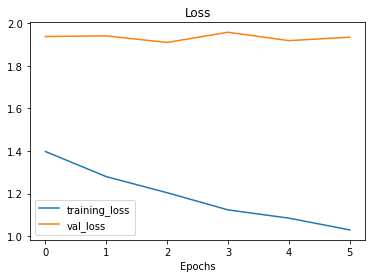

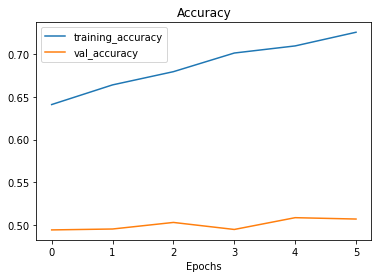

In [ ]:
plot_loss_curves(history_1) # this will not show the accurate results bcz it will show only 5 epochs

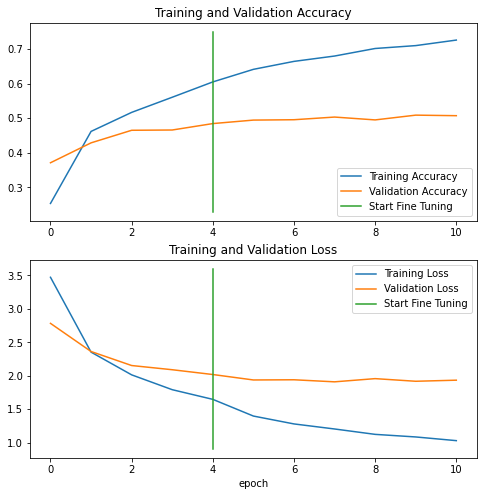

In [ ]:
compare_historys(original_history = history,
                 new_history = history_1,
                 initial_epochs = initial_epochs)

**NOTE:** As you can see our model is overfitting (lines are far apart)
so we have to reduce the overfitting but for now it is fine lets see the predictions on actual images

## Saving and exporting the model (ERROR)
because if we have to incorporate the model into the app we have to save and export it

In [ ]:
# Saving
# model.save("drive/MyDrive/101_Food_mini_model")

# using h5 format rather then savedModel format because default format was cauing as error and I learned it
# from stackoverflow
# this will cause an error cant save the model apprently

In [ ]:
# load and evaluate the model
# loaded_model = tf.keras.models.load_model("drive/MyDrive/101_Food_mini_model.h5")

In [ ]:
# loaded_model.evaluate(test_data)

## Evaluating the 101Food Mini Model across all classes

Lets make some predictions, visualize them and later find out which 'predictions' were most wrong

Downloading the pretrained model from the github so that we are on the same page **ERROR**.

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [ ]:
# unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load in saved model

# model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# loaded_model_results = model.evaluate(test_data)

In [ ]:
evaluation_results = model.evaluate(test_data)

790/790 [==============================] - 102s 129ms/step - loss: 1.5965 - accuracy: 0.5785


## Making Predictions

In [ ]:
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 97s 121ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
len(preds_probs[0]), sum(preds_probs[0])

(101, 0.9999999277709151)

Softmax gives prediction propability array which of give pred probs to each class per test image. so if we sum a single test image pred prob it should be 1 and the highest value in tha array will represent the prediction class of the model of the image.

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability '0' looks like:\n {preds_probs[0]}")
print(f"The class with the highest prediction probability per sample 0: {preds_probs[0].argmax()}")
print(f"The Class with the highest prediction perbability '0' belongs to: {train_data_all_10_percent.class_names[preds_probs[0].argmax()]} ")

Number of prediction probabilities for sample 0: 101
What prediction probability '0' looks like:
 [3.3301362e-01 1.0268591e-04 1.1903556e-01 5.0606474e-08 7.0631372e-06
 1.9939869e-06 7.2337360e-05 1.5540867e-05 2.0781692e-02 7.0211710e-04
 3.2395401e-06 2.6946769e-05 2.8249566e-03 8.3261136e-07 1.6822096e-02
 2.0897691e-03 3.8974842e-05 1.2641085e-03 3.5092968e-03 1.4531869e-05
 5.2292232e-04 3.9575090e-05 4.4010792e-04 2.6920997e-04 7.3138450e-04
 1.3563366e-03 2.9664143e-04 4.1214462e-05 1.1396863e-01 6.4142887e-03
 4.0731052e-06 1.8596367e-03 3.7264719e-03 2.4265187e-06 1.1160973e-02
 4.8793408e-05 2.3047463e-04 6.8986596e-04 1.3935014e-02 8.5896472e-06
 9.9675590e-04 1.7500268e-03 2.7616883e-03 7.5755495e-05 4.4265224e-05
 8.2750244e-05 2.5043460e-03 3.8382615e-04 3.8258795e-06 3.6296386e-02
 2.5454350e-04 5.6494569e-05 7.4408866e-02 5.5588377e-03 8.9969428e-05
 2.4065448e-02 3.4441713e-02 1.0430303e-03 8.5241869e-03 1.5101511e-04
 9.3616586e-07 3.2775444e-03 9.6840439e-03 2.42784

In [ ]:
# Get the pred class for each label
pred_classes = preds_probs.argmax(axis = 1)

pred_classes

array([  0,   0,   0, ..., 100,  93,  23])

In [ ]:
len(pred_classes)

25250

In [ ]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [ ]:
# to get our test labels we have to unravel the batchDataset
y_labels = []

for images, labels in test_data.unbatch(): # unbatching takes alot of time
  y_labels.append(labels.numpy().argmax()) # argmax because our labels are one-hot encoded

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**NOTE:** y_labels are in 0 bcz we had set the shuffle = False so they are in order, so means first 10 belong to class label 0.

In [ ]:
pred_classes[:10]

array([ 0,  0,  0, 43, 79, 78, 29,  0,  9,  0])

In [ ]:
pred_classes[:10] == y_labels[:10]

array([ True,  True,  True, False, False, False, False,  True, False,
        True])

## Evaluating our model's prediction

One way to check that our model's prediction are in the same order as the test labels array is to fine the accuracy score

In [ ]:
# lets first try the sklearn accuracy score function and see what comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.5784950495049505

In [ ]:
evaluation_results

[1.5964794158935547, 0.5784950256347656]

In [ ]:
import numpy as np

np.isclose(sklearn_accuracy,evaluation_results[1])

True

## Confusion Matrix:

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Chnaged( plot xlabels vertically)
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)
  
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

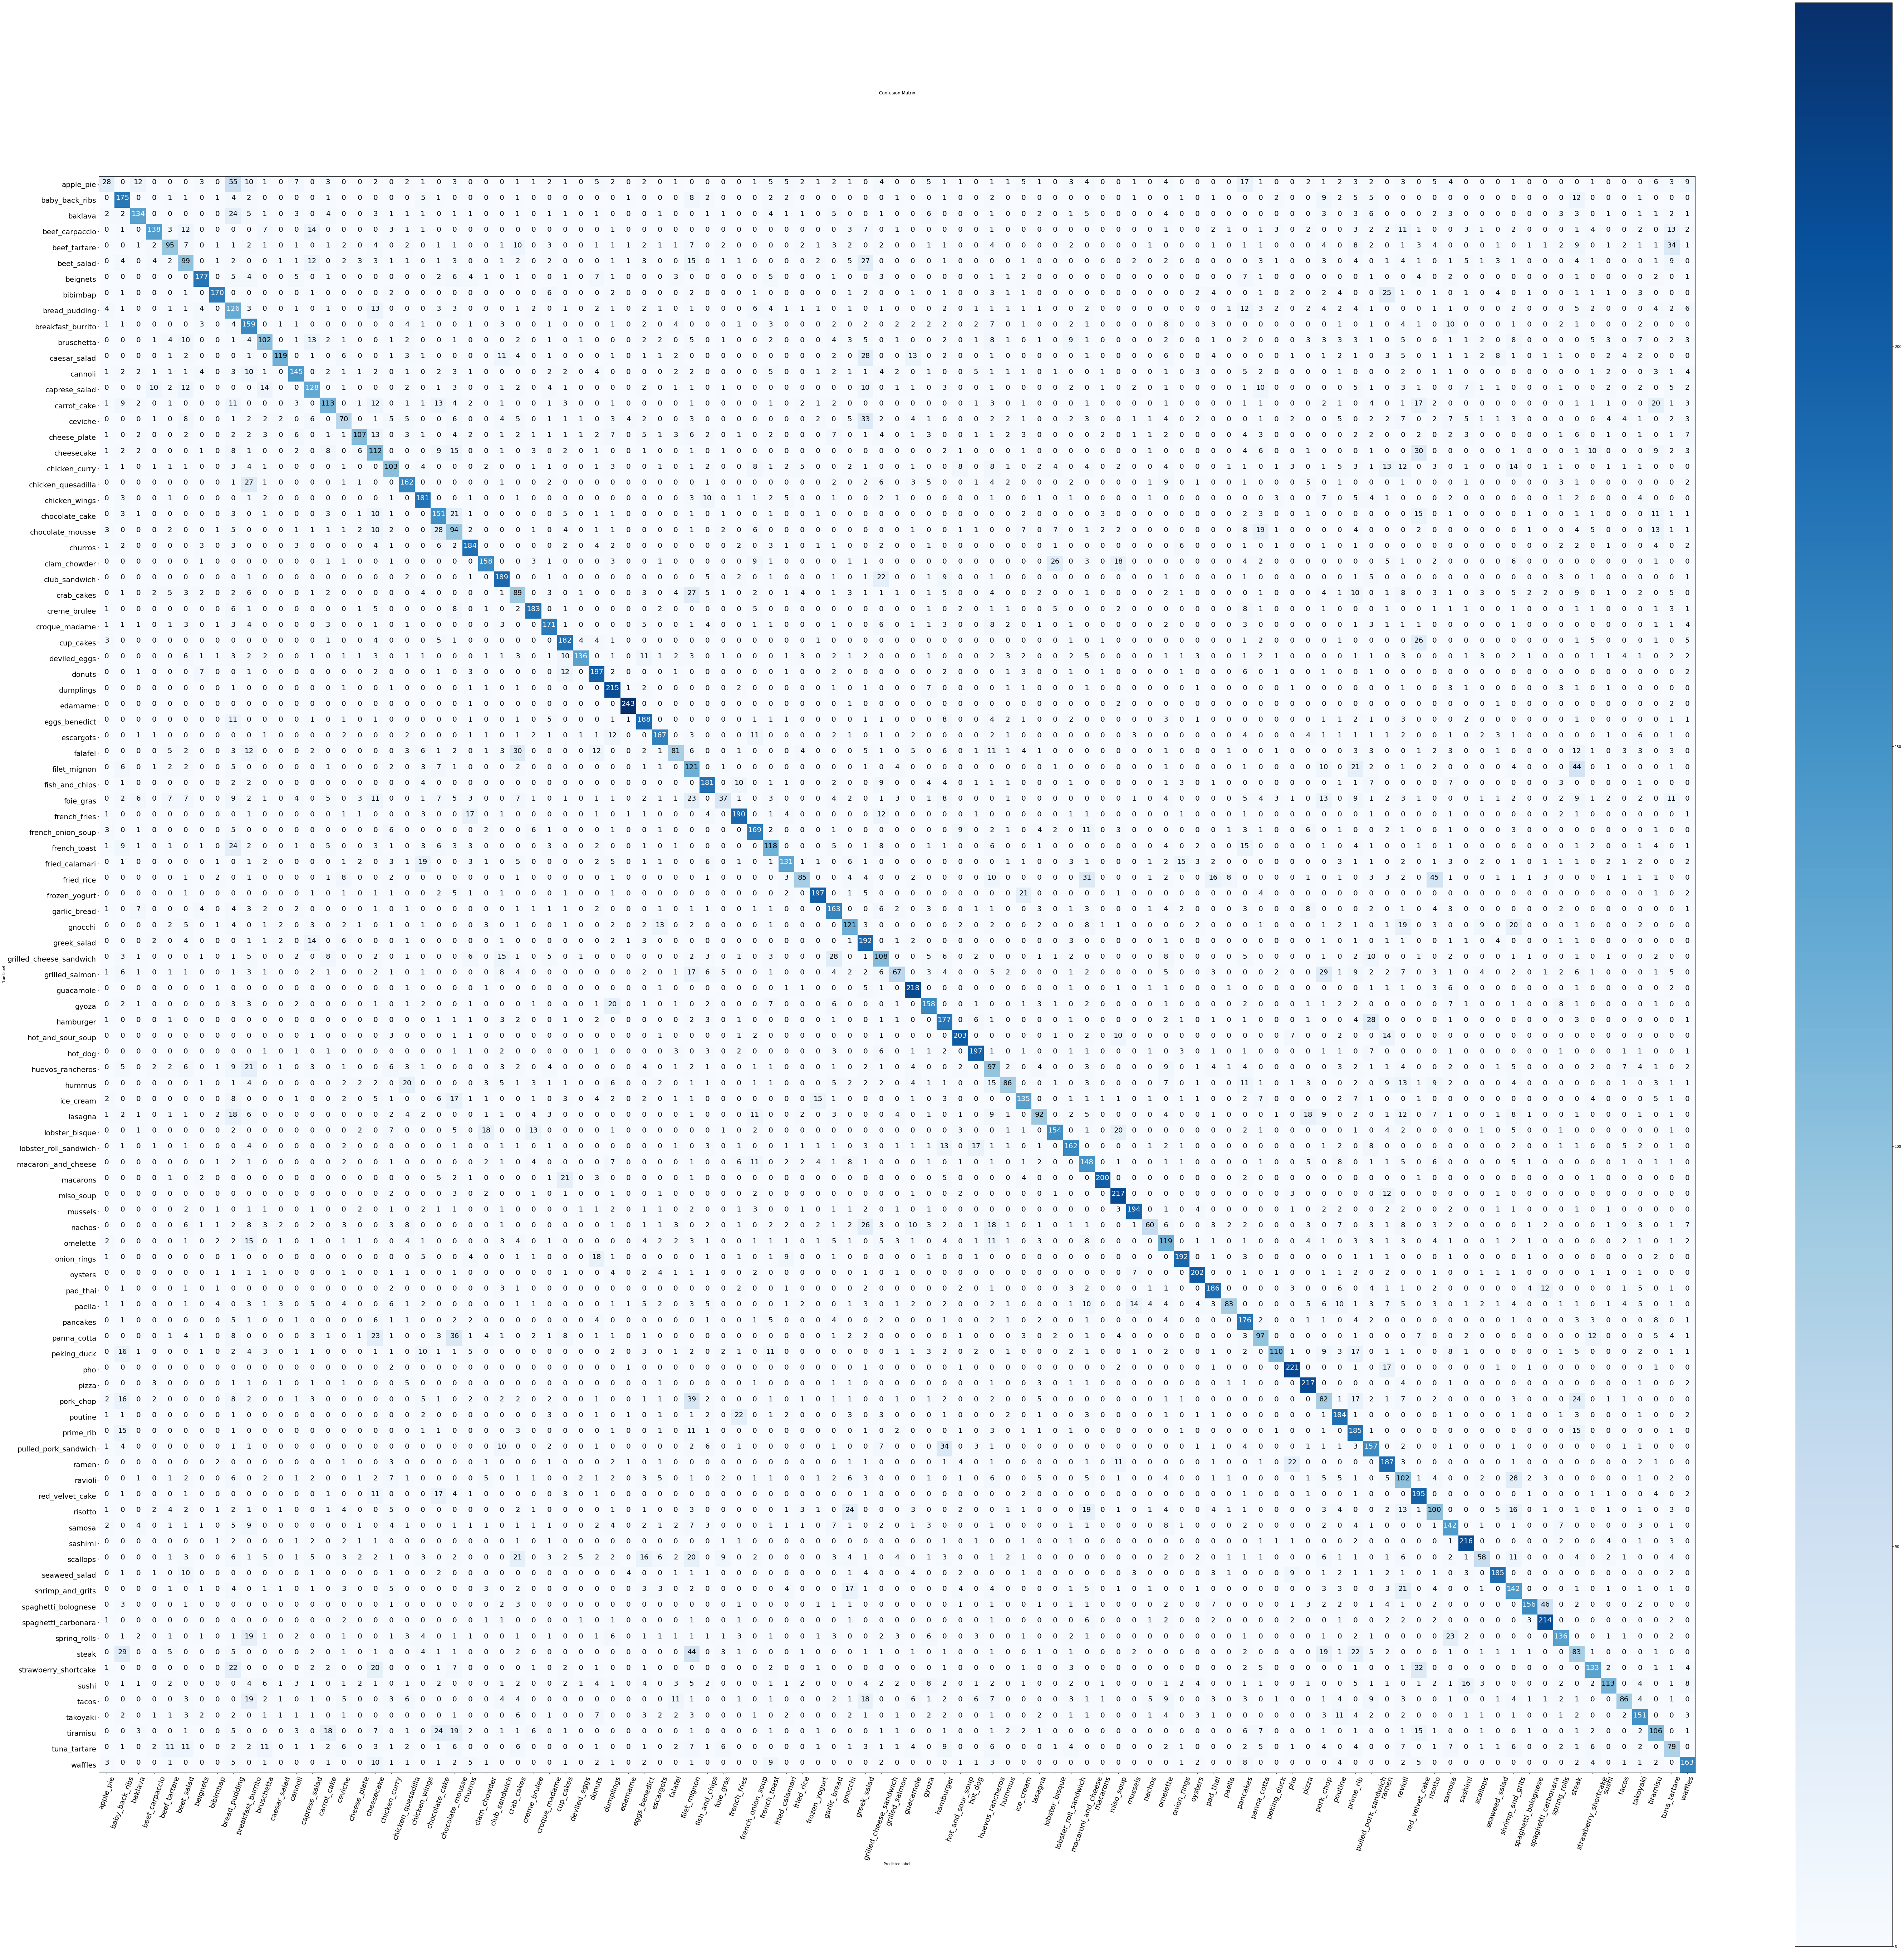

In [ ]:
make_confusion_matrix(y_true = y_labels, 
                      y_pred = pred_classes,
                      classes = test_data.class_names,
                      figsize = (100, 100),
                      text_size = 20)

## Classification report

precision    recall  f1-score   support

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.11      0.17       250
           1       0.51      0.70      0.59       250
           2       0.70      0.54      0.61       250
           3       0.78      0.55      0.64       250
           4       0.55      0.38      0.45       250
           5       0.39      0.40      0.39       250
           6       0.79      0.71      0.75       250
           7       0.85      0.68      0.76       250
           8       0.26      0.50      0.34       250
           9       0.38      0.64      0.48       250
          10       0.54      0.41      0.47       250
          11       0.85      0.48      0.61       250
          12       0.69      0.58      0.63       250
          13       0.53      0.51      0.52       250
          14       0.58      0.45      0.51       250
          15       0.43      0.28      0.34       250
          16       0.73      0.43      0.54       250
          17       0.35    

Viasulizing the number

In [ ]:
# dictionary of classification report
classification_report_dic = classification_report(y_true=y_labels, y_pred = pred_classes, output_dict=True)
classification_report_dic

### F1-score:

In [ ]:
class_names = test_data.class_names
class_names

In [ ]:
class_f1_score = {}

for k, v in classification_report_dic.items():
  if k == "accuracy":
    break
  else:
    class_f1_score[class_names[int(k)]] = v["f1-score"]
class_f1_score

In [ ]:
# lets sort the values
import pandas as pd

f1_score = pd.DataFrame({"class_names":list(class_f1_score.keys()), 
                         "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending = False)

In [ ]:
f1_score[:-10]

class_names  f1-score
33           edamame  0.949219
63          macarons  0.860215
75               pho  0.829268
86           sashimi  0.818182
69           oysters  0.811245
..               ...       ...
50    grilled_salmon  0.366120
66            nachos  0.356083
26        crab_cakes  0.353877
37      filet_mignon  0.353285
56  huevos_rancheros  0.344583

[91 rows x 2 columns]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))

score = plt.barh(range(len(f1_score)), f1_score["f1-score"].values)

ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score["class_names"])
ax.set_xticklabels("F1-score")
ax.set_title("F1-score of 101Food Mini")
ax.invert_yaxis();

## Visualizing the prediction on our test Images

In [ ]:
# load and preprocess Images

def load_and_prep_image(filename, img_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels = 3)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/225.
  else:
    return img



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


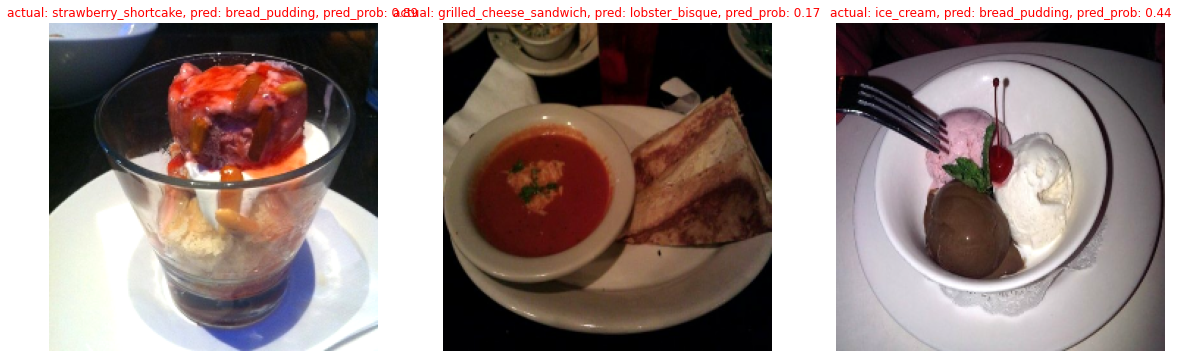

In [ ]:
import os
import random

plt.figure(figsize=(20, 10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  file_path = test_dir + class_name + "/" + filename
  

  img = load_and_prep_image(file_path, scale = False)

  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/225)

  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, pred_prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False);

### Finding the most wrong prediction

In [ ]:
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis = 1),
                        "y_true_labels": [class_names[i] for i in y_labels],
                        "y_pred_labels": [class_names[i] for i in pred_classes]})
pred_df[:10]

img_path  ...      y_pred_labels
0  b'/content/101_food_classes_10_percent/test/ap...  ...          apple_pie
1  b'/content/101_food_classes_10_percent/test/ap...  ...          apple_pie
2  b'/content/101_food_classes_10_percent/test/ap...  ...          apple_pie
3  b'/content/101_food_classes_10_percent/test/ap...  ...     fried_calamari
4  b'/content/101_food_classes_10_percent/test/ap...  ...          prime_rib
5  b'/content/101_food_classes_10_percent/test/ap...  ...            poutine
6  b'/content/101_food_classes_10_percent/test/ap...  ...          cup_cakes
7  b'/content/101_food_classes_10_percent/test/ap...  ...          apple_pie
8  b'/content/101_food_classes_10_percent/test/ap...  ...  breakfast_burrito
9  b'/content/101_food_classes_10_percent/test/ap...  ...          apple_pie

[10 rows x 6 columns]

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...          True
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong.head()

img_path  ...  pred_correct
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
14691  b'/content/101_food_classes_10_percent/test/ic...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
9110   b'/content/101_food_classes_10_percent/test/fa...  ...         False

[5 rows x 7 columns]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


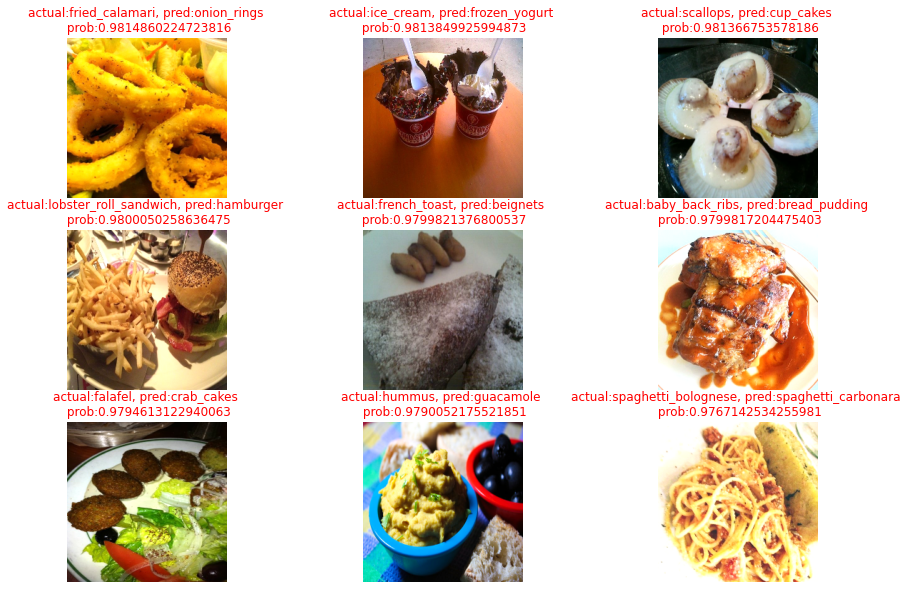

In [ ]:
image_to_view = 9
start_index = 30

plt.figure(figsize = (15,10))
for i, row in enumerate(top_100_wrong[start_index : start_index + image_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/225.)
  plt.title(f"actual:{y_true_classname}, pred:{y_pred_classname} \n prob:{pred_prob}", c="r")
  plt.axis(False)

### Predicting on our Images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-01-08 15:17:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  23.4MB/s    in 0.5s    

2022-01-08 15:18:00 (23.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


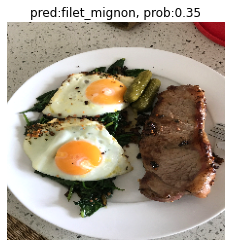

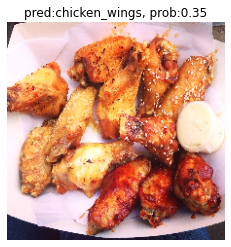

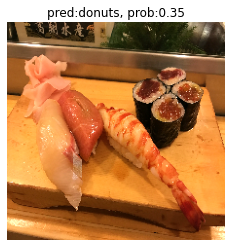

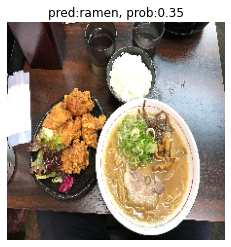

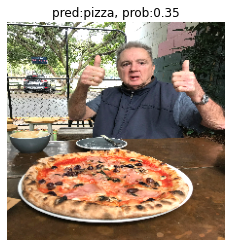

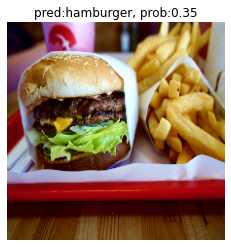

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(filename = img, scale = False)

  pred_probs = model.predict(tf.expand_dims(img , axis = 0))
  pred_class = class_names[pred_probs.argmax()]

  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred:{pred_class}, prob:{pred_prob.max():.2f}")
  plt.axis(False)

